In [4]:
import botorch
import gpytorch
import matplotlib.pyplot as plt
import torch

from utils.data_generation import GPData
from utils.training import fit_gp_model

plt.style.use("./utils/styles.mplstyle")

## Exercises

### 8.3: Manual computation of constrained EI

In [2]:
def objective_fn(x):
    return -((x + 1) ** 2) * torch.sin(2 * x + 2) / 5 + 1 + x / 3

def cost(x):
    return -(0.1 * objective_fn(x) + objective_fn(x - 4)) / 3 + x / 3 - 0.5

In [3]:
lb, ub = -5, 5
bounds = torch.tensor([[lb], [ub]], dtype=torch.float)
xs = torch.linspace(lb, ub, 100)
objective_ys = objective_fn(xs)
cost_ys = cost(xs)

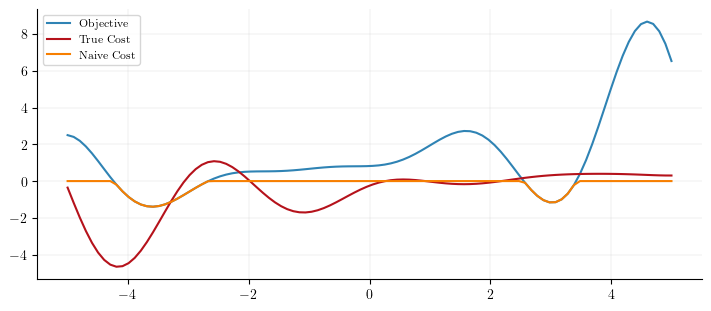

In [5]:
plt.figure(figsize=(7, 3))
plt.plot(xs, objective_ys, label="Objective")
plt.plot(xs, cost_ys, label="True Cost")
plt.plot(xs, torch.where(objective_ys < 0.0, objective_ys, torch.tensor(0.0)), label="Naive Cost");
plt.legend();

One of the problems with defining a cost function naively like this is that you may be introducing a bias into the cost function at certain values. E.g. in the Naive Cost above, kinks are introduced at -3.8, -2.2, etc. This can be problematic as the cost function is not differentiable at these points.

In [6]:
class GPModel(gpytorch.models.ExactGP, botorch.models.gpytorch.GPyTorchModel):
    _num_outputs = 1

    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=1)
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [7]:
torch.manual_seed(0)

n = 3
train_x = bounds[0] + (bounds[1] - bounds[0]) * torch.rand(n, 1)
train_utility = objective_fn(train_x).flatten()
train_cost = cost(train_x).flatten()

In [9]:
objective_data = GPData(train_x, train_utility, xs, objective_ys)
cost_data = GPData(train_x, train_cost, xs, cost_ys)

In [10]:
obj_model, obj_likelihood = fit_gp_model(GPModel, objective_data, num_train_iters=100)
cost_model, cost_likelihood = fit_gp_model(GPModel, cost_data, num_train_iters=100)

100%|██████████| 100/100 [00:00<00:00, 1378.00it/s]


In [11]:
with torch.no_grad():
    utlity_pred_dist = obj_likelihood(obj_model(xs))
    utility_pred_mean = utlity_pred_dist.mean
    utility_pred_lower, utility_pred_upper = utlity_pred_dist.confidence_region()

    cost_pred_dist = cost_likelihood(cost_model(xs))
    cost_pred_mean = cost_pred_dist.mean
    cost_pred_lower, cost_pred_upper = cost_pred_dist.confidence_region()

### Manual computation

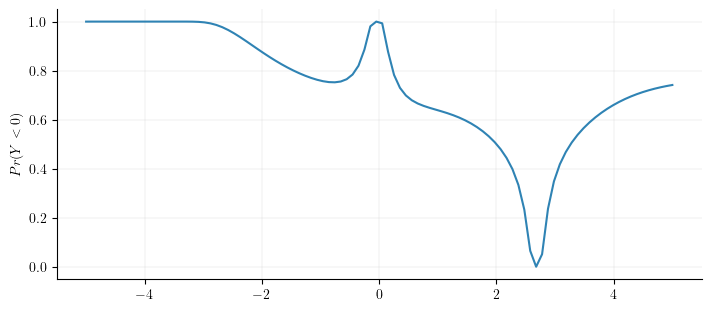

In [22]:
# compute the probability of feasibility for each point in the test set
normal = torch.distributions.Normal(cost_pred_mean, cost_pred_dist.stddev)

# CDF of probability that xs[i] < 0
feasibility_prob = normal.cdf(torch.zeros(1))

plt.figure(figsize=(7, 3))
plt.plot(xs, feasibility_prob)
plt.ylabel("$Pr(Y < 0)$");

In [30]:
ei = botorch.acquisition.ExpectedImprovement(
    obj_model,
    best_f=train_utility[train_cost <= 0].max()
)

model_list = botorch.models.ModelListGP(obj_model, cost_model)
constrained_ei = botorch.acquisition.ConstrainedExpectedImprovement(
    model=model_list,
    best_f=train_utility[train_cost <= 0].max(),
    objective_index=0,
    constraints={1: [None, 0]}
)

with torch.no_grad():
    ei_score = ei(xs[:, None, None])
    constrained_ei_score = constrained_ei(xs[:, None, None])

In [32]:
# manual computation is identical to the botorch implementation
assert torch.isclose(ei_score * feasibility_prob, constrained_ei_score, atol=1e-3).all()

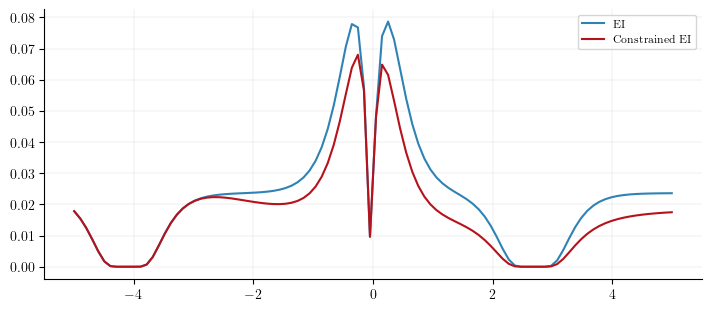

In [31]:
plt.figure(figsize=(7, 3))
plt.plot(xs, ei_score, label="EI")
plt.plot(xs, constrained_ei_score, label="Constrained EI")
plt.legend();

In [ ]:
from botorch.models import SingleTaskGP
from botorch.acquisition import ConstrainedExpectedImprovement
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood

# Sample training data
import numpy as np

# Number of training points
n = 20

# Simulate train_X
train_X = torch.linspace(-5, 5, n).reshape(-1, 1)

# Simulate train_Y
# Objective function (e.g., a quadratic function)
objective = torch.tensor(train_X**2 + np.random.normal(0, 0.5, size=train_X.shape), dtype=torch.float32)

# Constraint function (e.g., a linear function)
constraint = torch.tensor(2 * train_X + np.random.normal(0, 0.2, size=train_X.shape), dtype=torch.float32)

# Combine to form train_Y
train_Y = torch.hstack([constraint, objective])

# Fit model
model = SingleTaskGP(train_X, train_Y)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_model(mll)

# Best observed objective value
best_f = train_Y[:, 1].max()

# Constraints: Non-negativity constraint on the first output
constraints = {0: (0.0, None)}  # {output_index: (lower_bound, upper_bound)}

# Create ConstrainedExpectedImprovement instance
cEI = ConstrainedExpectedImprovement(model, best_f=best_f, objective_index=1, constraints=constraints)

# Test points (for evaluation)
test_X = torch.linspace(-5, 5, 1000).reshape(-1, 1)

# Evaluate Constrained Expected Improvement
cei_values = cEI(test_X)


### 8.5: Constrained optimization of airplane design

In [5]:
from utils.data_generation import flight_objective_fn

In [6]:
def flight_cost(X):
    X = X * 20 - 10

    part1 = (X[..., 0] - 1) ** 2

    i = X.new(range(2, 5))
    part2 = torch.sum(i * (2.0 * X[..., 1:] ** 2 - X[..., :-1]) ** 2, dim=-1)

    return -(part1 + part2) / 100_000 + 2

In [7]:
class GPModel(gpytorch.models.ExactGP, botorch.models.gpytorch.GPyTorchModel):
    _num_outputs = 1

    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=4)
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [8]:
num_queries = 50
num_repeats = 10
strategy = "CEI"
default_value = -2
feasible_incumbents = torch.ones((num_repeats, num_queries)) * default_value

In [9]:
for trial in range(num_repeats):
    print(f"experiment: {trial}")

    lb, ub = 0.0, 1.0
    bounds = torch.stack([lb * torch.ones(4), ub * torch.ones(4)])

    train_x = bounds[0] + (bounds[1] - bounds[0]) * torch.rand(1, 4)
    obj_train_y = flight_objective_fn(train_x)
    cost_train_y = flight_cost(train_x)

    obj_data = GPData(train_x, obj_train_y)
    cost_data = GPData(train_x, cost_train_y)

    for i in range(num_queries):
        # print(f"best feasible objective: {feasible_incumbents[trial, :i].max()}")

        feasible_flag = (cost_train_y <= 0).any()
        if feasible_flag:
            feasible_incumbents[trial, i] = obj_train_y[cost_train_y <= 0].max()

        obj_model, obj_likelihood = fit_gp_model(GPModel, obj_data, num_train_iters=100)
        cost_model, cost_likelihood = fit_gp_model(GPModel, cost_data, num_train_iters=100)

        if feasible_flag:
            best_f = obj_train_y[cost_train_y <= 0].max()
        else:
            best_f = default_value

        if strategy == "CEI":
            model_list = botorch.models.ModelListGP(obj_model, cost_model)
            policy = botorch.acquisition.ConstrainedExpectedImprovement(
                model=model_list,
                best_f=best_f,
                objective_index=0,
                constraints={1: [None, 0]}
            )

        next_x, acq_val = botorch.optim.optimize_acqf(
            policy,
            bounds=bounds,
            q=1,
            num_restarts=100,
            raw_samples=500,
        )
        
        next_obj = flight_objective_fn(next_x)
        next_cost = flight_cost(next_x)

        obj_train_y = torch.cat([obj_train_y, next_obj])
        cost_train_y = torch.cat([cost_train_y, next_cost])
        train_x = torch.cat([train_x, next_x])

experiment: 0


100%|██████████| 100/100 [00:00<00:00, 1351.78it/s]
/Users/gabestechschulte/miniforge3/envs/bayesopt/lib/python3.11/site-packages/botorch/optim/optimize.py:359: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
100%|██████████| 100/100 [00:00<00:00, 1299.05it/s]


experiment: 1


100%|██████████| 100/100 [00:00<00:00, 1332.15it/s]


experiment: 2


100%|██████████| 100/100 [00:00<00:00, 1269.15it/s]
/Users/gabestechschulte/miniforge3/envs/bayesopt/lib/python3.11/site-packages/botorch/optim/optimize.py:359: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
100%|██████████| 100/100 [00:00<00:00, 1367.59it/s]
/Users/gabestechschulte/miniforge3/envs/bayesopt/lib/python3.11/site-packages/botorch/optim/optimize.py:359: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
100%|██████████| 100/1

experiment: 3


100%|██████████| 100/100 [00:00<00:00, 1362.62it/s]


experiment: 4


100%|██████████| 100/100 [00:00<00:00, 1373.04it/s]


experiment: 5


100%|██████████| 100/100 [00:00<00:00, 1366.62it/s]
/Users/gabestechschulte/miniforge3/envs/bayesopt/lib/python3.11/site-packages/botorch/optim/optimize.py:359: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
100%|██████████| 100/100 [00:00<00:00, 1313.19it/s]
/Users/gabestechschulte/miniforge3/envs/bayesopt/lib/python3.11/site-packages/botorch/optim/optimize.py:359: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
100%|██████████| 100/1

experiment: 6


100%|██████████| 100/100 [00:00<00:00, 1390.24it/s]


experiment: 7


100%|██████████| 100/100 [00:00<00:00, 1396.12it/s]


experiment: 8


100%|██████████| 100/100 [00:00<00:00, 1352.12it/s]
/Users/gabestechschulte/miniforge3/envs/bayesopt/lib/python3.11/site-packages/botorch/optim/optimize.py:359: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
100%|██████████| 100/100 [00:00<00:00, 1414.87it/s]


experiment: 9


100%|██████████| 100/100 [00:00<00:00, 1338.42it/s]


In [10]:
def visualize_experiment(result, n_queries, n_experiments, label=None):

    def ci(y):
        return 2 * y.std(axis=0) / torch.sqrt(torch.tensor(n_experiments))

    mean_incumbent = result.mean(axis=0)
    ci_incumbent = ci(result)

    fig, ax = plt.subplots(1, 1, figsize=(7, 3))
    ax.plot(torch.arange(n_queries), mean_incumbent, label="Mean")
    ax.fill_between(
        torch.arange(n_queries),
        mean_incumbent - ci_incumbent,
        mean_incumbent + ci_incumbent,
        alpha=0.2,
        label="CI",
    )
    ax.grid(True)
    ax.legend()

    return fig, ax

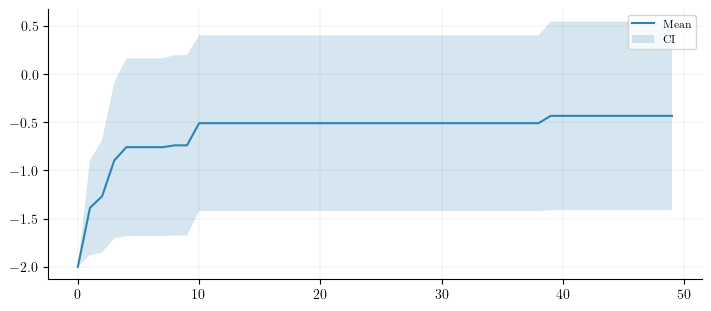

In [12]:
fig, ax = visualize_experiment(feasible_incumbents, num_queries, num_repeats)